In [1]:
# Add anna to the path
import os
import sys
module_path = os.path.abspath(os.path.join('../../../anna'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = "../../../data"

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import anna.data.dataset.reuters21578 as reuters
import anna.model.premade as models
import anna.summary.extract as summary

tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

# Colors for Plots
colors = [(31, 119, 180),  (174, 199, 232), (255, 127, 14),  (255, 187, 120),
          (44, 160, 44),   (152, 223, 138), (214, 39, 40),   (255, 152, 150),
          (148, 103, 189), (197, 176, 213), (140, 86, 75),   (196, 156, 148),
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34),  (219, 219, 141), (23, 190, 207),  (158, 218, 229)]

for i in range(len(colors)):    
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.)

In [3]:
# Load data
train_docs, test_docs, unused_docs, labels = reuters.fetch_and_parse(DATA_DIR)

# Standard Reuters Config
val_size = 777
epochs = 20
shuffle = 10000

In [4]:
# Create MLP classifier
for drop in [.0, .1, .2, .3, .4, .5]:
    # Create default trainer
    model = models.AVGxBR(DATA_DIR, labels,
                          name="avg_br_{}".format(drop),
                          dropout=drop,
                          folder_name="model-dropout")

    # Train and evaluate
    print("Model: {}, Drop: {}".format(model, drop))
    model.train(train_docs, test_docs,
                val_size=val_size, epochs=epochs, shuffle=shuffle)

    # Delete to save memory
    del model

In [3]:
model_path = os.path.join(DATA_DIR, "model-dropout")
metrics_path = os.path.join(model_path, "metrics.json")

# Uncomment to load from runs
metrics = summary.parse_all(model_path)
with open(metrics_path, "w") as f:
    json.dump(metrics, f)

# Uncomment to load from file
#with open(metrics_path, "r") as f:
#    metrics = json.load(f)

In [4]:
num_epochs = min([len(m["val"]["perf/accuracy"]) for m in metrics.values()])
plt.rc('font', size=20)

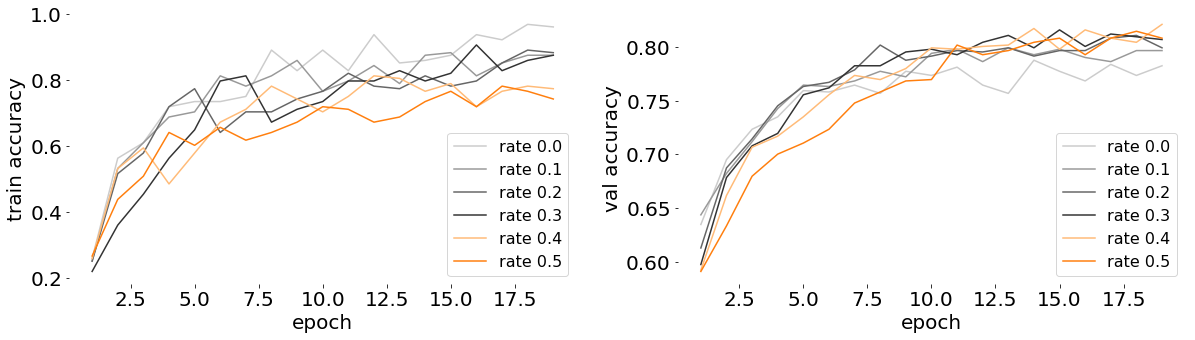

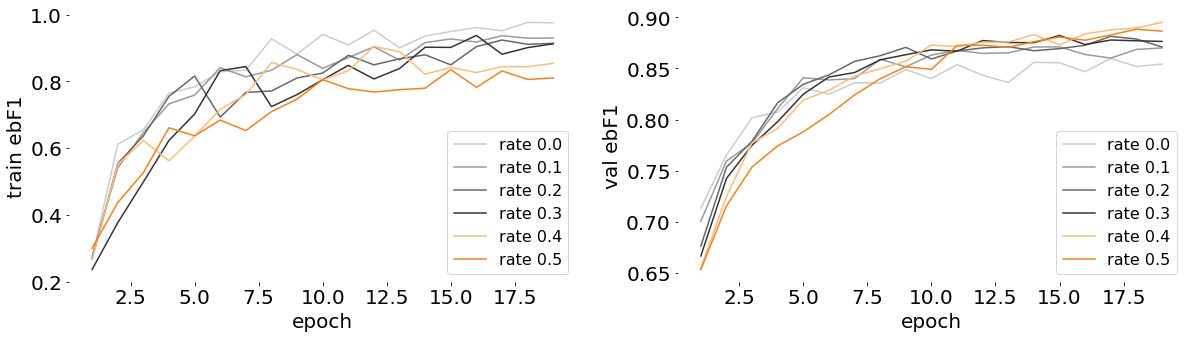

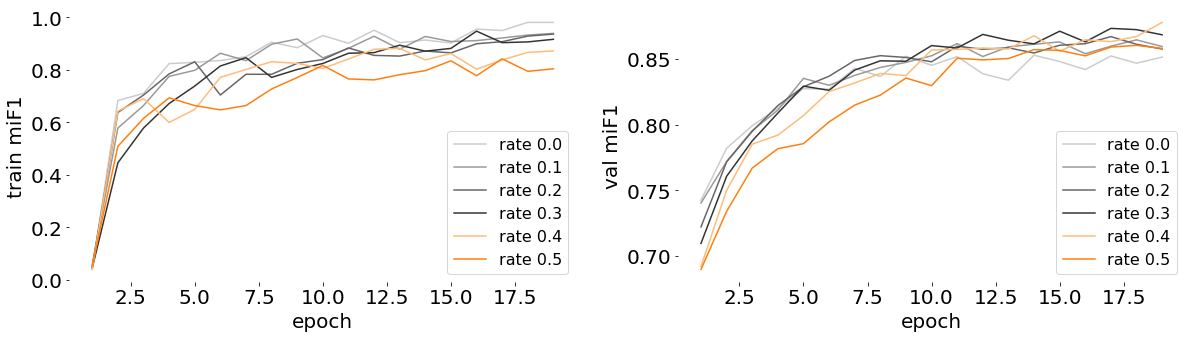

In [18]:
remove_first = 1

x = range(num_epochs)[remove_first:]
for metric_name in ["perf/accuracy", "perf/ebF1", "perf/miF1"]:
    pre, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])


    for train_set, ax in [("train", ax1), ("val", ax2)]:
        ax.set_xlabel("epoch")
        ax.set_ylabel("{} {}".format(train_set, metric_name[len("perf/"):]))
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        for name, metric in sorted(metrics.items())[::2]:
            y = metric[train_set][metric_name][remove_first:num_epochs]
            y = [m[1] for m in y]
            drop = float(name[len("avg_br_"):])
            color = str(1. - min([drop * 2 + 0.20, 1.0]))
            color = colors[3] if drop == .4 else color
            color = colors[2] if drop == .5 else color
            ax.plot(x, y, color=color, label="rate {}".format(drop))

        ax.legend(loc=4, fontsize=16)